In [10]:
import sys
sys.path.append('../.') 

# BIBLIOTEKI
import pandas as pd
from srai.regionalizers import H3Regionalizer, geocode_to_region_gdf
from srai.embedders import CountEmbedder
from src.embedders.osm_data_embedder import OSMDataEmbedder
from sklearn.preprocessing import LabelEncoder
import torch
from src.graph.create_graph import OSMEmbedderGraph

from src.baseline_models.GCN.supervised_node_classification import SupervisedNodeClassificationGNN
from src.baseline_models.GCN.GraphData import GraphData
from src.baseline_models.GCN.gcn import GCNModel

from sklearn.model_selection import train_test_split
import pytorch_lightning as pl

import pandas as pd
import torch

from src.baseline_models.classifier import CustomClassifier

In [2]:
# import importlib
# importlib.reload(src.baseline_models.GCN.supervised_node_classification)

In [3]:
# Podział mapy Wrocławia na obszary, zliczenie danych cech w obszarze, połączenie X z Y (Y - liczba wypadów w danym obszarze)

area = geocode_to_region_gdf("Wrocław, Poland")
regionalizer = H3Regionalizer(resolution=8)
embedder = CountEmbedder()
query = {"highway": True}

embeddings = OSMDataEmbedder(area=area, embedder=embedder, regionalizer=regionalizer, query=query)
embeddings_feature_gdf = embeddings.make_embeddings()

df_accidents = pd.read_csv('../data/embeddings.csv')

gdf = pd.merge(embeddings_feature_gdf, df_accidents, on='region_id', how='inner')

In [4]:
# Stworzenie etykiet określających poziom ryzyka na podstawie liczby wypadków + zakodowanie ich 

bins = [-1, 0, float("inf")]  # Bins: (-1, 0], (0, 2], (2, 12], (12, inf)
label_names = ['no risk', 'risk']
gdf['risk_level'] = pd.cut(gdf['rok_2023'], bins=bins, labels=label_names, right=True)

labels = gdf['risk_level']
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

gdf['risk_level'] = labels_encoded
gdf= gdf.set_index('region_id')
gdf = gdf.drop(['rok_2023'], axis=1)
gdf.head(3)

,geometry,highway_bridleway,highway_bus_stop,highway_construction,highway_corridor,highway_crossing,highway_cycleway,highway_elevator,highway_footway,highway_give_way,...,highway_tertiary_link,highway_track,highway_traffic_mirror,highway_traffic_signals,highway_trunk,highway_trunk_link,highway_turning_circle,highway_turning_loop,highway_unclassified,risk_level
region_id,,,,,,,,,,,,,,,,,,,,,
881e204357fffff,"POLYGON ((16.86824 51.14477, 16.86583 51.14049...",0,9,0,0,9,0,0,181,0,...,0,16,0,0,0,0,1,0,4,1
881e20409dfffff,"POLYGON ((17.04724 51.10730, 17.04482 51.10302...",0,9,0,0,51,27,1,389,0,...,5,0,1,23,0,0,0,1,0,1
881e204717fffff,"POLYGON ((17.13201 51.13502, 17.12958 51.13074...",0,2,0,0,1,0,0,3,0,...,0,13,0,0,0,0,0,0,0,0


In [5]:
# Wybór cech + stworzenie bazowego gdf 

selected_features = ['highway_bridleway',
 'highway_bus_stop',
 'highway_elevator',
 'highway_give_way',
 'highway_motorway',
 'highway_passing_place',
 'highway_primary_link',
 'highway_secondary_link',
 'highway_stop',
 'highway_traffic_signals',
 'highway_turning_circle']

gdf_base = gdf[['geometry']+selected_features+['risk_level']]
gdf_base.head(3)

,geometry,highway_bridleway,highway_bus_stop,highway_elevator,highway_give_way,highway_motorway,highway_passing_place,highway_primary_link,highway_secondary_link,highway_stop,highway_traffic_signals,highway_turning_circle,risk_level
region_id,,,,,,,,,,,,,
881e204357fffff,"POLYGON ((16.86824 51.14477, 16.86583 51.14049...",0,9,0,0,0,0,0,0,0,0,1,1
881e20409dfffff,"POLYGON ((17.04724 51.10730, 17.04482 51.10302...",0,9,1,0,0,0,0,4,0,23,0,1
881e204717fffff,"POLYGON ((17.13201 51.13502, 17.12958 51.13074...",0,2,0,0,0,0,0,0,0,0,0,0


In [6]:
# Tworzenie obiektu Data z torch_geometric
G = OSMEmbedderGraph(gdf_base, "risk_level",  'shortest_path')
data = G.createGraph_Data()

Statistics:
--------------------------------------------------
Nodes:  422
Edges:  88831
Nodes dim:  11
Nodes class 2
Directed:  False
Graph density:  100.0 %


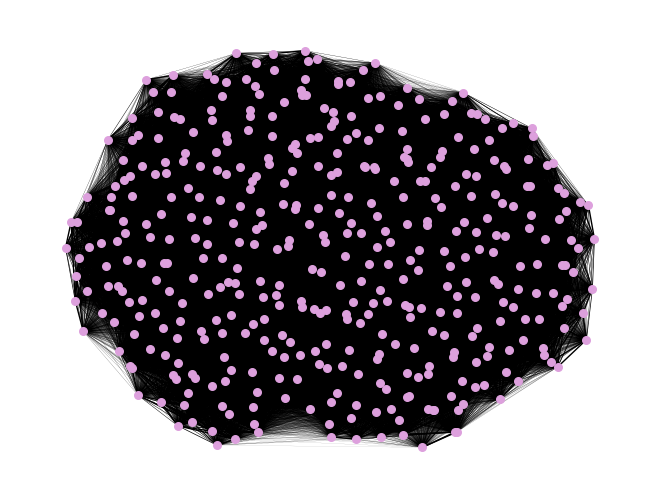

In [7]:
# Wświetlenie grafu + statystkiki 
G.show_statistics() 
G.graph_visualization() 

---

In [8]:
import pytorch_lightning as pl
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import torch
from torch import nn
from torch_geometric.data import Data
from typing import List, Optional, Tuple
from sklearn.decomposition import PCA
# import umap
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'


## GCN model

In [11]:
num_features = data.num_features
hidden_dim = 256
out_dim = 128
num_classes = len(data.y.unique())

gnn = GCNModel(in_dim=num_features, hidden_dim=hidden_dim, out_dim=out_dim)

model = SupervisedNodeClassificationGNN(gnn=gnn, emb_dim=out_dim, num_classes=num_classes, lr=0.0001)

In [12]:
nodes_labels = {'node': [i for i in range(len(data.y))], 'label': data.y.cpu().numpy()}
df_to_split = pd.DataFrame(nodes_labels)

df_train, df_test = train_test_split(df_to_split, test_size=0.2, random_state=42, stratify=df_to_split['label'])
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=42, stratify=df_test['label'])

train_nodes = df_train['node']
val_nodes = df_val['node']
test_nodes = df_test['node']

train_mask = []   
val_mask = []
test_mask = []

for i in range(len(data.y)):

  if i in train_nodes:
    train_mask.append(True)
    val_mask.append(False)
    test_mask.append(False)
  elif i in val_nodes:
    train_mask.append(False)
    val_mask.append(True)
    test_mask.append(False)
  elif i in test_nodes:
    train_mask.append(False)
    val_mask.append(False)
    test_mask.append(True)

data.train_mask = torch.tensor(train_mask).cpu()
data.val_mask = torch.tensor(val_mask).cpu()
data.test_mask = torch.tensor(test_mask).cpu()

In [13]:
# Trenowanie modelu

trainer = pl.Trainer(max_epochs=15)
datamodule = GraphData([data])
trainer.fit(model=model, datamodule=datamodule)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\kiera\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\utils\tensorboard\__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
c:\Users\kiera\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\utils\tensorboard\__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  ) < LooseVersion("1.15"):

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | GCNModel   | 36.0 K
1 | _classification_head | Sequential | 16.8 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
52.7 K    Trainable params
0         Non-trainable params
52

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\kiera\AppData\Local\Programs\Python\Python38\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
c:\Users\kiera\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kiera\AppData\Local\Programs\Python\Python38\lib\site-packages\pytorch_lightning\utilities\data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\kiera\AppData\Local\Programs\Python\Python38\lib\s

Training: |          | 0/? [00:00<?, ?it/s]

c:\Users\kiera\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kiera\AppData\Local\Programs\Python\Python38\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\result.py:212: You called `self.log('step', ...)` in your `training_step` but the value needs to be floating to be reduced. Converting it to torch.float32. You can silence this warning by converting the value to floating point yourself. If you don't intend to reduce the value (for instance when logging the global step or epoch) then you can use `self.logger.log_metrics({'step': ...})` instead.


Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\kiera\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kiera\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\kiera\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kiera\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\kiera\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kiera\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\kiera\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kiera\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\kiera\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kiera\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\kiera\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kiera\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\kiera\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\kiera\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\kiera\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\kiera\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\kiera\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\kiera\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
`Trainer.fit` stopped: `max_epochs=15` reached.


---

### Results

In [14]:
trainer.test(model=model, datamodule=datamodule, verbose=False)

c:\Users\kiera\AppData\Local\Programs\Python\Python38\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

c:\Users\kiera\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kiera\AppData\Local\Programs\Python\Python38\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\result.py:212: You called `self.log('step', ...)` in your `test_step` but the value needs to be floating to be reduced. Converting it to torch.float32. You can silence this warning by converting the value to floating point yourself. If you don't intend to reduce the value (for instance when logging the global step or epoch) then you can use `self.logger.log_metrics({'step': ...})` instead.


[{'step': 15.0,
  'test/auc_weighted': 0.706896551724138,
  'test/f1_weighted': 0.5432816537467701,
  'test/precision_weighted': 0.45484045429962144,
  'test/recall_weighted': 0.6744186046511628,
  'test/accuracy_weighted': 0.6744186046511628}]

In [15]:
test_auc = trainer.test(model=model, datamodule=datamodule, verbose=False)[0]["test/auc_weighted"]

z, y, y_pred = trainer.predict(model=model, datamodule=datamodule)[0]

print(f'AUC test = {test_auc * 100.:.2f}[%]')

c:\Users\kiera\AppData\Local\Programs\Python\Python38\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

c:\Users\kiera\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kiera\AppData\Local\Programs\Python\Python38\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

AUC test = 70.69[%]


In [16]:
gdf2 = gdf_base.copy()
gdf2['predictions'] = y_pred

---

## Linear Regression

In [ ]:
train_nodes_array = df_train['node'].values
X_train = data.x[train_nodes_array].cpu().numpy()
y_train = df_train['label'].values

test_nodes_array = df_test['node'].values
X_test = data.x[test_nodes_array].cpu().numpy()
y_test = df_test['label'].values


In [ ]:
logistic_reg = CustomClassifier()
logistic_reg.train(X_train, y_train)
y_pred = logistic_reg.predict(X_test)

In [ ]:
metrics, conf_matrix_disp = logistic_reg.evaluate(X_test, y_test, y_pred)
metrics

{'F1 Score': 0.6472493985565356,
 'Accuracy': 0.6511627906976745,
 'Precision': 0.670874861572536,
 'Recall': 0.6511627906976745,
 'AUC Score': 0.8442500095467217}

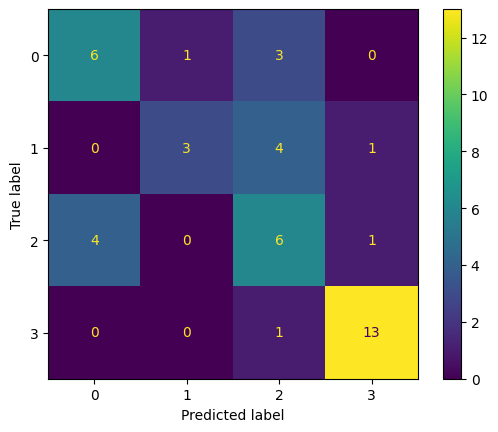

In [ ]:
conf_matrix_disp.plot()